In [2]:
import xarray as xr
from glob import glob
import sys
import pandas as pd
import otps
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta
import numpy as np
import scipy
from scipy import ndimage as nd
import matplotlib.pyplot as plt

import datacube
from datacube.utils import geometry
from datacube.utils.geometry import CRS

def interp_tides(x_coords, y_coords, z_coords, resolution=500, sigma=20):
    
    # Extract xy and elev points
    points_xy = np.vstack([y_coords, x_coords]).T
    values_elev = z_coords

    # Create grid to interpolate into
    x_size, upleft_x, y_size, upleft_y = resolution, x_coords.min(), resolution, y_coords.max()
    bottomright_x = x_coords.max() 
    bottomright_y = y_coords.min()    
    grid_y, grid_x = np.mgrid[upleft_y:bottomright_y:1j * y_size, upleft_x:bottomright_x:1j * x_size]

    # Interpolate x, y and z values using linear/TIN interpolation
    out = scipy.interpolate.griddata(points_xy, values_elev, (grid_y, grid_x), method='linear')

    # Calculate nearest
    nearest_inds = nd.distance_transform_edt(input=np.isnan(out), return_distances=False, return_indices=True)
    out = out[tuple(nearest_inds)]

    # Apply guassian filter
    out = nd.filters.gaussian_filter(out, sigma=sigma)
    return out[:,:,0]

def lag_linregress_3D(x, y, lagx=0, lagy=0, first_dim='time'):
    
    """
    Takes two xr.Datarrays of any dimensions (input data could be a 1D time series, or for example, have 
    three dimensions e.g. time, lat, lon), and return covariance, correlation, regression slope and intercept, 
    p-value, and standard error on regression between the two datasets along their aligned first dimension.  
    
    Datasets can be provided in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    
    Parameters
    ----------    
    x, y : xarray DataArray
        Two xarray DataArrays with any number of dimensions, both sharing the same first dimension
    lagx, lagy : int, optional
        Optional integers giving lag values to assign to either of the data, with lagx shifting x, and lagy 
        shifting y with the specified lag amount. 
    first_dim : str, optional
        An optional string giving the name of the first dimension on which to align datasets. The default is
        'time'.
    
    Returns
    -------
    cov, cor, slope, intercept, pval, stderr : xarray DataArray
        Covariance, correlation, regression slope and intercept, p-value, and standard error on 
        regression between the two datasets along their aligned first dimension.  

    """ 
    
    #1. Ensure that the data are properly alinged to each other. 
    x, y = xr.align(x, y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx != 0:
        
        # If x lags y by 1, x must be shifted 1 step backwards. But as the 'zero-th' value is nonexistant, xr 
        # assigns it as invalid (nan). Hence it needs to be dropped:
        x = x.shift(**{first_dim: -lagx}).dropna(dim=first_dim)
        
        # Next re-align the two datasets so that y adjusts to the changed coordinates of x:
        x,y = xr.align(x, y)

    if lagy!=0:
        
        y = y.shift(**{first_dim: -lagy}).dropna(dim=first_dim)
        x, y = xr.align(x, y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n = y.notnull().sum(dim=first_dim)
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd = x.std(axis=0)
    ystd = y.std(axis=0)
    
    #4. Compute covariance along first axis
    cov = np.sum((x - xmean) * (y - ymean), axis=0) / (n)
    
    #5. Compute correlation along time axis
    cor = cov / (xstd * ystd)
    
    #6. Compute regression slope and intercept:
    slope = cov / (xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n - 2) / np.sqrt(1 - cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval = t.sf(tstats, n - 2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov, cor, slope, intercept, pval, stderr


def RMSE(x, y):
    
    """
    Computes root mean squared error (RMSE) from two lists of observed and modelled values. 
    
    Last modified: April 2018
    Author: Robbi Bishop-Taylor    
    
    :attr x: list of observed values (e.g. validation data or field observations)
    :attr y: list of modelled values
    
    :returns: float of computed RMSE 
    """
    
    return ((y - x) ** 2).mean() ** 0.5


# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import DEADataHandling, SpatialTools, DEAPlotting, BandIndices

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Create datacube instance
dc = datacube.Datacube(app='Tidal tagging')

# Create 'query' based on the longitudes, latitudes and time provided above
query = {'y': (-15.68847186, -16.04168290),
         'x': (145.34355739, 145.47173940),
         'crs': 'EPSG:4326',
         'time': ('2010-10-01', '2010-12-31'),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25)}

DEAPlotting.display_map(x=query['x'], y=query['y'], crs=query['crs'])

In [ ]:
# Load in only clear Landsat observations with < 1% unclear values
data = DEADataHandling.load_clearlandsat(dc=dc, query=query, 
                                       bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1', 'swir2'], 
                                       masked_prop=0.0, mask_pixel_quality=True) 

data['NDWI'] = BandIndices.calculate_indices(data, 'NDWI')
data['MNDWI'] = BandIndices.calculate_indices(data, 'MNDWI')
data['WI'] = BandIndices.calculate_indices(data, 'WI')
data['AWEI_noshadow'] = BandIndices.calculate_indices(data, 'AWEI_noshadow')
data['AWEI_shadow'] = BandIndices.calculate_indices(data, 'AWEI_shadow')
data.NDWI.isel(time = 2).plot(size=10)
                                                        

## Test ITEM confidence for WA vs OTPS

In [ ]:
lat, lon = -14.9109, 128.3326

# Calculate old tide heights
observed_datetimes = data.time.data.astype('M8[s]').astype('O').tolist()
observed_timepoints = [otps.TimePoint(lon, lat, dt) for dt in observed_datetimes]
observed_predictedtides = otps.predict_tide(observed_timepoints)
tideheights_old = [predictedtide.tide_m for predictedtide in observed_predictedtides]
data['tideheights_old'] = xr.DataArray(tideheights_old, [('time', data.time)])

# Calculate new tide heights
# tideheights_new = sealevel_ds.sel(time=observed_datetimes, method='nearest').sealevel.values.tolist()
tideheights_new = sealevel_ds.interp(time=observed_datetimes).sealevel.values.tolist()
data['tideheights_new'] = xr.DataArray(tideheights_new, [('time', data.time)])


In [ ]:
water_perc = (data.MNDWI > 0).sum(dim=['x', 'y']) * 100 / (len(data.x) * len(data.y))
cor = np.corrcoef(x=data.tideheights_old.values, y=water_perc)[1,0].round(3)
plt.scatter(x=data.tideheights_old.values, y=water_perc.values)
plt.title(f'Old tide heights\nPearson correlation: {cor}');

In [ ]:
water_perc = (data.MNDWI > 0).sum(dim=['x', 'y']) * 100 / (len(data.x) * len(data.y))
cor = np.corrcoef(x=data.tideheights_new.values, y=water_perc)[1,0].round(3)
plt.scatter(x=data.tideheights_new.values, y=water_perc.values)
plt.title(f'New tide heights\nPearson correlation: {cor}');


In [ ]:
cov, cor_old, slope_old, intercept, pval_old, stderr_old = lag_linregress_3D(data['tideheights_old'], data['NDWI'], lagx=0, lagy=0, first_dim='time')
cov, cor_new, slope_new, intercept, pval_new, stderr_new = lag_linregress_3D(data['tideheights_new'], data['NDWI'], lagx=0, lagy=0, first_dim='time')
(cor_new - cor_old).plot(cmap='RdBu', size=5, aspect=2)

In [ ]:
cov, cor_old, slope_old, intercept, pval_old, stderr_old = lag_linregress_3D(data['tideheights_old'], data['MNDWI'], lagx=0, lagy=0, first_dim='time')
cov, cor_new, slope_new, intercept, pval_new, stderr_new = lag_linregress_3D(data['tideheights_new'], data['MNDWI'], lagx=0, lagy=0, first_dim='time')
(cor_new - cor_old).plot(cmap='RdBu', size=5, aspect=2)

In [ ]:
cov, cor_old, slope_old, intercept, pval_old, stderr_old = lag_linregress_3D(data['tideheights_old'], data['AWEI_shadow'], lagx=0, lagy=0, first_dim='time')
cov, cor_new, slope_new, intercept, pval_new, stderr_new = lag_linregress_3D(data['tideheights_new'], data['AWEI_shadow'], lagx=0, lagy=0, first_dim='time')
(cor_new - cor_old).plot(cmap='RdBu', size=5, aspect=2)

In [ ]:
cov, cor_old, slope_old, intercept, pval_old, stderr_old = lag_linregress_3D(data['tideheights_old'], data['AWEI_noshadow'], lagx=0, lagy=0, first_dim='time')
cov, cor_new, slope_new, intercept, pval_new, stderr_new = lag_linregress_3D(data['tideheights_new'], data['AWEI_noshadow'], lagx=0, lagy=0, first_dim='time')
(cor_new - cor_old).plot(cmap='RdBu', size=5, aspect=2)

In [ ]:
cov, cor_old, slope_old, intercept, pval_old, stderr_old = lag_linregress_3D(data['tideheights_old'], data['WI'], lagx=0, lagy=0, first_dim='time')
cov, cor_new, slope_new, intercept, pval_new, stderr_new = lag_linregress_3D(data['tideheights_new'], data['WI'], lagx=0, lagy=0, first_dim='time')
(cor_new - cor_old).plot(cmap='RdBu', size=5, aspect=2)

In [ ]:
high_old = data.tideheights_old < data.tideheights_new.quantile(0.1)
high_new = data.tideheights_new < data.tideheights_new.quantile(0.1)

In [ ]:
data.sel(time=high_old).median(dim='time')[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, size=5, aspect=1)

In [ ]:
data.sel(time=high_new).median(dim='time')[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, size=5, aspect=1)

In [ ]:
# import numpy as np
intervals = list(zip(np.linspace(data['tideheights_old'].min(), data['tideheights_old'].max(), 11),
                     np.linspace(data['tideheights_new'].min(), data['tideheights_new'].max(), 11)))

out = []
out_ndwi = []

for i, (min_tide_old, min_tide_new) in enumerate(intervals):    
 
    try:
        
        max_tide_old, max_tide_new = intervals[i+1]
        old_subset = data.where((data.tideheights_old >= min_tide_old) & (data.tideheights_old <= max_tide_old), drop = True)
        new_subset = data.where((data.tideheights_new >= min_tide_new) & (data.tideheights_new <= max_tide_new), drop = True)
        print(len(old_subset.time), len(new_subset.time))

        model_comparison = xr.concat([old_subset.NDWI.std(dim = 'time'),
                                      new_subset.NDWI.std(dim = 'time')], 
                                      dim=xr.DataArray(['old', 'new'], dims='model', name='model'))  
        model_comparison.plot(col='model', size=6, aspect=1, vmin=0, vmax=0.5)
        out.append(model_comparison)

        model_comparison = xr.concat([old_subset.NDWI.median(dim = 'time'),
                                      new_subset.NDWI.median(dim = 'time')], 
                                      dim=xr.DataArray(['old', 'new'], dims='model', name='model'))              
        out_ndwi.append(model_comparison)
            
    except:
        print('Skip')
   


In [ ]:
xr.concat(out).mean(dim='concat_dims').plot(col='model', size=6, aspect=2, cmap='RdYlBu_r')

In [ ]:
xr.concat(out).mean(dim='concat_dims').diff(dim='model').plot(size=6, aspect=2.3, robust=True)

## Rolling NIDEM

In [ ]:
data_tidal = data.swap_dims({'time': 'tideheights_old'}).sortby('tideheights_old')
data_tidal = data_tidal[['NDWI', 'MNDWI', 'WI', 'AWEI_noshadow', 'AWEI_shadow', 'red', 'green', 'blue']]
data_tidal['tideheights_var'] = data_tidal.tideheights_old
data_tidal

# data_tidal = data_tidal.rolling(tideheights_old = 30, center=True, min_periods=1).median(dim='tideheights_old')
# data_tidal


In [ ]:
from datacube.helpers import write_geotiff
from skimage.filters import threshold_otsu




test = dict(NDWI=data_tidal.isel(tideheights_old=0)['NDWI'],
            MNDWI=data_tidal.isel(tideheights_old=0)['MNDWI'],
            AWEI_shadow=data_tidal.isel(tideheights_old=0)['AWEI_shadow'],
#             rgb=data_tidal.isel(tideheights_old=0)[['red','green', 'blue']],
#             ternary=data_tidal.isel(tideheights_old=0)[['NDWI', 'MNDWI', 'AWEI_shadow']],
           )


for key, to_write in test.items():
    otsu = threshold_otsu(to_write.values[np.isfinite((to_write > 0).values)])
    print(key, otsu)
    to_write = to_write.to_dataset()
    to_write.attrs['affine'] = data.affine
    to_write.attrs['crs'] = data.crs
    write_geotiff(f'test_{key}.tif', to_write)
    write_geotiff(f'test_{key}_classified.tif', (to_write > 0).astype(np.int32))
    write_geotiff(f'test_{key}_otsu.tif', (to_write > otsu).astype(np.int32))
    

In [ ]:
custom_attrs = {'elev_m': data_tidal['tideheights_var'].values}
custom_attrs_dtypes = {'elev_m': 'float:9.2'}

SpatialTools.contour_extract(z_values=0.25,
                             ds_array=data_tidal.ndwi,
                             ds_crs=data.geobox.crs,
                             ds_affine=data.geobox.affine,
                             output_shp='nidem_test_otsu.shp',
                             dim='tideheights_old',
                             attribute_data=custom_attrs,
                             attribute_dtypes=custom_attrs_dtypes,
                             verbose=False)

In [ ]:
mndwi = (data.green - data.swir1) / (data.green + data.swir1)
# mndwi = (data.green - data.nir) / (data.green + data.nir)

In [ ]:
%load_ext autoreload
%autoreload 2

# Import modules
import sys
import datacube

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import DEAPlotting

# Set up datacube instance
dc = datacube.Datacube(app='Contour extraction')
    
# Define a Landsat query
landsat_query = {'lat': (-35.25, -35.35),
                 'lon': (149.05, 149.17),
                 'time': ('2016-02-15', '2016-03-01'),
                 'output_crs': 'EPSG:3577',
                 'resolution': (-25, 25)}

# Import sample Landsat data
landsat_data = dc.load(product='ls8_nbart_albers', 
                       group_by='solar_day',
                       **landsat_query)
    
# # Plot a single observation (option 1)
# DEAPlotting.rgb(ds=landsat_data.isel(time=0))

# # Plot a single observation (option 1)
# DEAPlotting.rgb(ds=landsat_data, index=0)

# # Plot multiple observations as a facet plot (option 1)
# DEAPlotting.rgb(ds=landsat_data, col='time')

# # Plot multiple observations as a facet plot (option 2)
# DEAPlotting.rgb(ds=landsat_data, index=[0, 1])

# # Increase contrast using `percentile_stretch`
# DEAPlotting.rgb(ds=landsat_data, index=[0, 1], 
#                 percentile_stretch=(0.02, 0.9))

# # Pass in any keyword argument to `xarray.plot.imshow()`, e.g. `aspect`. For more 
# # options, see: http://xarray.pydata.org/en/stable/generated/xarray.plot.imshow.html  
# DEAPlotting.rgb(ds=landsat_data, index=[0, 1], 
#                 percentile_stretch=(0.02, 0.9), aspect=1.2)

# Export the RGB image to file using `savefig_path`
DEAPlotting.rgb(ds=landsat_data, index=[0, 1], 
                percentile_stretch=(0.02, 0.9), aspect=1.2, 
                savefig_path='output_image_test.png')



In [ ]:
# rgb(ds=data, col='time', col_wrap=3)

## Download UWA extreme sea levels data

Loading ls5
    Loading 182 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Skipping ls8; no valid data for query
Returning ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Computing NDWI using formula `(green - nir)/(green + nir)` for Landsat or `(green - nir_1)/(green + nir_1)` for Sentinel 2


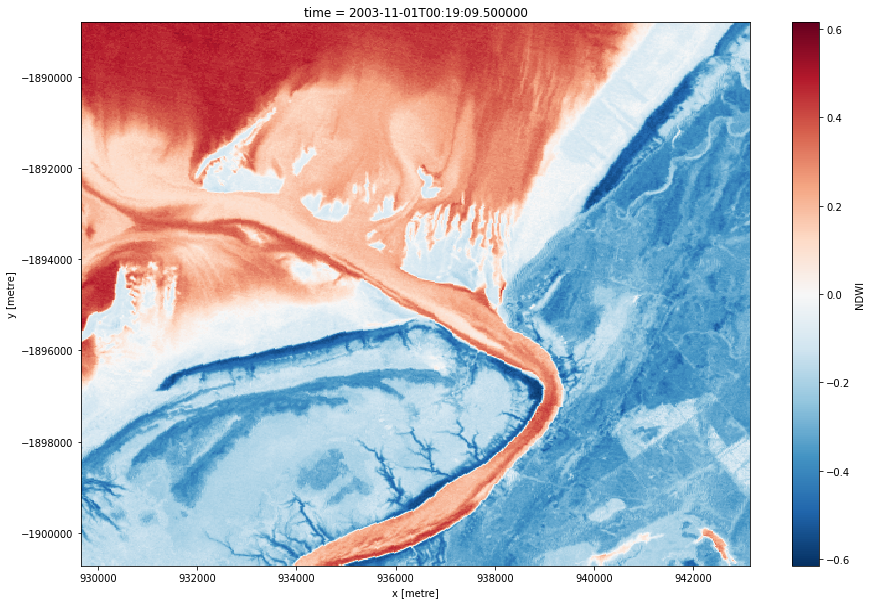

In [98]:
# Create datacube instance
dc = datacube.Datacube(app='Tidal tagging')

# Create 'query' based on the longitudes, latitudes and time provided above
# query = {'y': (-15.68847186, -16.04168290),
#          'x': (145.34355739, 145.47173940),

lon_min, lat_max = 140.75, -17.41
lon_max, lat_min = 140.87, -17.51


query = {'y': (lat_min, lat_max),
         'x': (lon_min, lon_max),
         'crs': 'EPSG:4326',
         'time': ('2003-10-01', '2008-12-31'),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25)}

DEAPlotting.display_map(x=query['x'], y=query['y'], crs=query['crs'])


# Load in only clear Landsat observations with < 1% unclear values
data = DEADataHandling.load_clearlandsat(dc=dc, query=query, 
                                       bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1', 'swir2'], 
                                       masked_prop=0.0, mask_pixel_quality=True) 

data['NDWI'] = BandIndices.calculate_indices(data, 'NDWI')
data.NDWI.isel(time = 2).plot(size=10)

## Load WA sea level into xarray format

In [99]:
import pandas as pd
import os

def load_sealevelx(data, sealevelx_dir='output_data/uwa_extremesealevels'):

    # Read in index linking IDs to lat/longs
    sealevelx_index_pd = pd.read_csv(f'{sealevelx_dir}/AUSTRALIA_2km_SCHISM_points.csv')

    # Identify coastal data points within dataset boundary
    bbox = data.geobox.geographic_extent.boundingbox
    sealevelx_index_pd = sealevelx_index_pd.loc[(sealevelx_index_pd.X > bbox.left) & 
                                                (sealevelx_index_pd.X < bbox.right) &
                                                (sealevelx_index_pd.Y > bbox.bottom) &
                                                (sealevelx_index_pd.Y < bbox.top)]
    
    sealevelx_paths = sealevelx_index_pd.apply(lambda x: f'{sealevelx_dir}/{int(x.ID):05d}_Data.nc', axis=1)
    sealevelx_paths = [file for file in sealevelx_paths if os.path.exists(file)]
    print(f'Extracting data for {len(sealevelx_paths)} coastal data points')    
    
    # Open all data as a dask xarray dataset
    all_nodes = xr.open_mfdataset(paths=sealevelx_paths, concat_dim='file').squeeze('coast_id')

    # Interpolate hourly results to get sea level estimates for exact acquisition time
    all_nodes = all_nodes.interp(time=data.time.data.astype('M8[s]').astype('O').tolist())

    # Select only required columns
    all_nodes  = all_nodes[['time', 'id', 'node', 'latitude', 'longitude', 'sealevel']]

    # Re-index to give latitude, longitude and time dimensions
    sealevelx_ds = all_nodes.set_index({'file': ['latitude', 'longitude']}).unstack()   
    
    # Convert to pandas dataframe with time, latitude, longitude columns
    sealevelx_pd = sealevelx_ds.sealevel.to_dataframe().dropna()
    
    return sealevelx_pd    


test = load_sealevelx(data, sealevelx_dir='output_data/uwa_extremesealevels')
test.head()

Extracting data for 12 coastal data points


sealevel
time                latitude   longitude           
2003-10-09 00:12:45 -17.497302 140.744830  401.7500
                    -17.485460 140.758226  419.9625
                    -17.476885 140.773673  412.1750
                    -17.474714 140.838337  406.0250
                    -17.472052 140.790920  410.6000

In [100]:
sealevel_means = test.groupby(['time']).median().sealevel.values
data['sealevel'] = xr.DataArray(sealevel_means, [('time', data.time)])

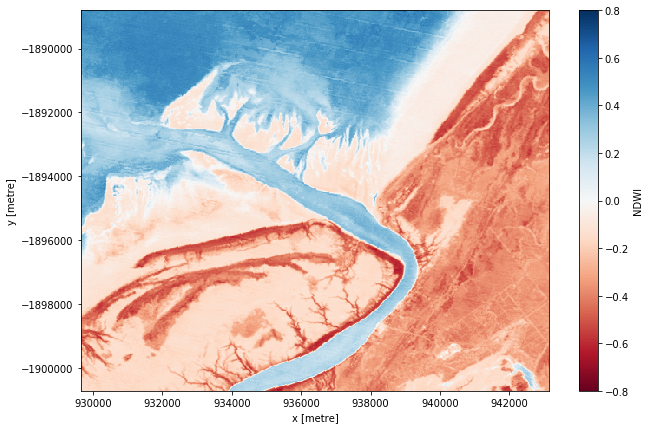

In [101]:
data.sel(time = (data.sealevel  > -3000) & (data.sealevel  < -1000)).NDWI.median(dim='time').plot(size=7, vmin=-0.8, vmax=0.8, cmap='RdBu')

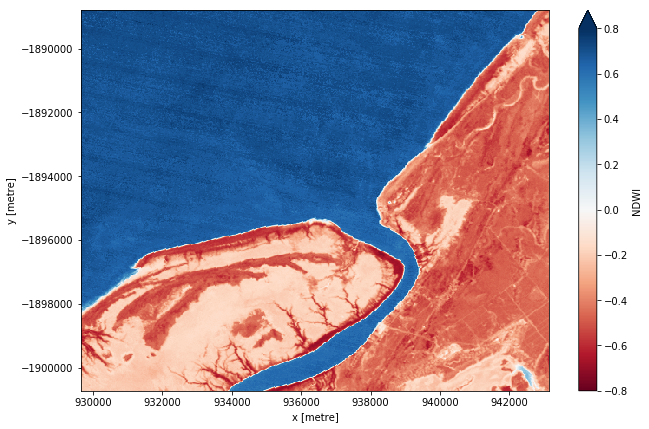

In [102]:
data.sel(time = (data.sealevel  > 1000) & (data.sealevel  < 2000)).NDWI.median(dim='time').plot(size=7, vmin=-0.8, vmax=0.8, cmap='RdBu')

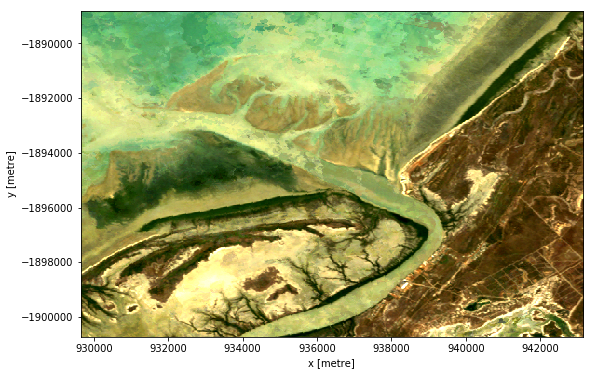

In [103]:
DEAPlotting.rgb(data.sel(time = data.sealevel < -1000).median(dim='time'))

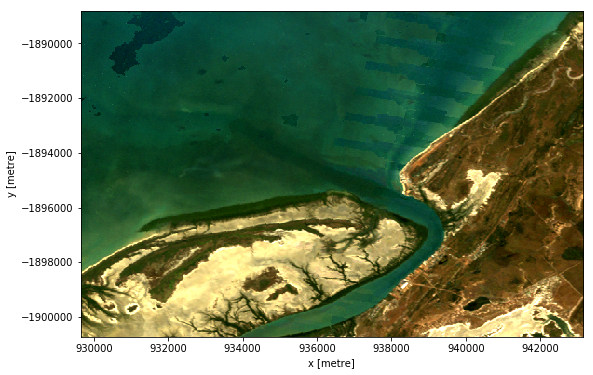

In [104]:
DEAPlotting.rgb(data.sel(time = data.sealevel > 1600).median(dim='time'))

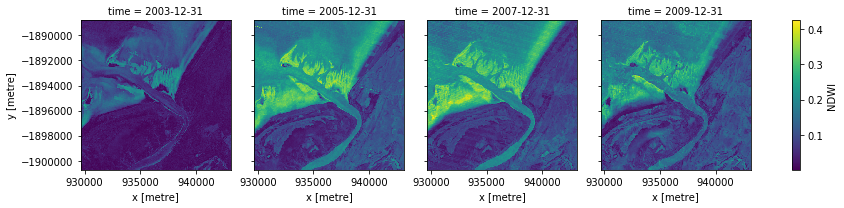

In [109]:
data.NDWI.sel(time = data.sealevel < 0).resample(time='2Y').std(dim='time').plot(col='time')

In [ ]:
data.sortby('sealevel').NDWI.plot(col='time', col_wrap=6)

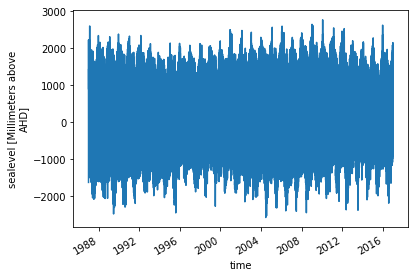

In [106]:
xr.open_dataset('output_data/uwa_extremesealevels/17603_Data.nc').sealevel.sel(time=slice('1987', '2018')).plot()

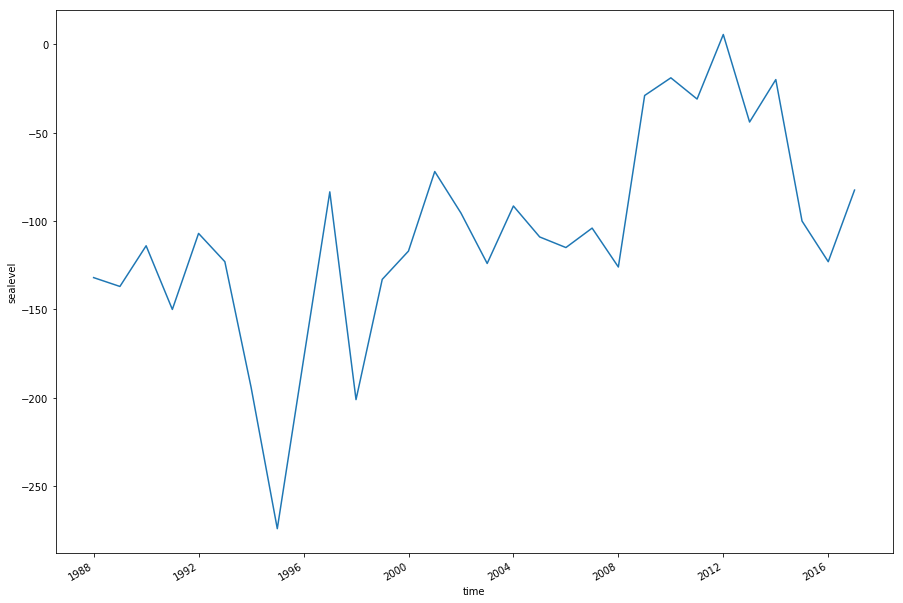

In [107]:
xr.open_dataset('output_data/uwa_extremesealevels/17603_Data.nc').sealevel.sel(time=slice('1987', '2018')).resample(time='Y').median().plot(size=10)

In [1]:
xr.open_dataset('output_data/uwa_extremesealevels/17603_Data.nc').sealevel.sel(time=slice('2004', '2006')).resample(time='M').mean().plot(size=10, alpha=0.5)

NameError: name 'xr' is not defined

In [ ]:
import pandas as pd
tide_points_pd = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Advanced_coastal/raw_data/AUSTRALIA_2km_SCHISM_points.csv')

y_max, x_min = -11.110152, 130.832455
y_min, x_max = -12.358548, 132.238351

tide_points_sel = tide_points_pd.loc[(tide_points_pd.X > x_min) & 
                                     (tide_points_pd.X < x_max) &
                                     (tide_points_pd.Y > y_min) &
                                     (tide_points_pd.Y < y_max)].copy()

tide_points_sel['path'] = tide_points_sel.apply(lambda x: 'output_data/uwa_extremesealevels/{0:05d}_Data.nc'.format(int(x.ID)), axis=1)
files = tide_points_sel['path'].to_list()
files = [file for file in files if os.path.exists(file)]
len(files)

In [ ]:
# Open all data
all_nodes = xr.open_mfdataset(paths=files, concat_dim='file').squeeze('coast_id')

# Interpolate hourly results to get sea level estimates for exact acquisition time
all_nodes = all_nodes.interp(time=data.time.data.astype('M8[s]').astype('O').tolist())

# Select only required timesteps
all_nodes  = all_nodes[['time', 'id', 'node', 'latitude', 'longitude', 'sealevel']]

# Re-index to give latitude, longitude and time dimensions
test = all_nodes.set_index({'file': ['latitude', 'longitude']}).unstack()

In [ ]:
test_df_subset = test.isel(time=0).sealevel.to_dataframe().dropna(axis=0).reset_index() 
test_df_subset

import seaborn as sns
sns.scatterplot(data =test_df_subset,  x='longitude', y='latitude', hue='sealevel')

In [ ]:
def interp_tides(x_vals, y_vals, z_vals, transform, out_shape, fill_nearest=None, gaussian=None):

    # Create grid to interpolate into
    x_size, _, upleft_x, _, y_size, upleft_y = transform[0:6]
    bottomright_y, bottomright_x = rasterio.transform.array_bounds(out_shape[0], 
                                                                   out_shape[1], 
                                                                   transform)[1:3]
    xi = np.linspace(upleft_x, bottomright_x, out_shape[1])
    yi = np.linspace(upleft_y, bottomright_y, out_shape[0])
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate
    out = scipy.interpolate.griddata((x_vals, y_vals), z_vals, (xi, yi), method='linear')
    
    # Calculate nearest
    if fill_nearest:
        
        nearest_inds = nd.distance_transform_edt(input=np.isnan(out), 
                                                 return_distances=False, 
                                                 return_indices=True)
        out = out[tuple(nearest_inds)]
        
    # Apply guassian filter
    if gaussian and fill_nearest:

        out = nd.filters.gaussian_filter(out, sigma=gaussian)
        
    return out[:,:,0]


import rasterio
from pyproj import Proj, transform
x_proj, y_proj = transform(Proj(init='epsg:4326'), Proj(init='epsg:3577'), 
                           test_df_subset.longitude.values,                                                                    
                           test_df_subset.latitude.values)


out = interp_tides(x_vals=x_proj, 
                   y_vals=y_proj, 
                   z_vals=test_df_subset[['sealevel']].values, 
                   transform=data.geobox.transform, 
                   out_shape=data.NDWI.shape[1:], 
                   fill_nearest=True,
                   gaussian=15)


# Get shoreline mask
coastline_gpd = gpd.read_file('/g/data/u46/users/adh547/shapefiles/australia/australia/cstauscd_r.shp')
coastline_gpd = coastline_gpd.loc[coastline_gpd.FEAT_CODE != 'sea']
coastline_gpd = coastline_gpd.to_crs(epsg=3577)
coastline_mask = rasterio.features.geometry_mask(coastline_gpd.geometry,
                                                 out_shape=data.NDWI.shape[1:],
                                                 transform=data.geobox.transform,
                                                 all_touched=False, invert=True)

# Remove land
out[coastline_mask] = np.nan
plt.imshow(out)

## Stats on sea level data

In [3]:
import pandas as pd
tide_points_pd = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Advanced_coastal/raw_data/AUSTRALIA_2km_SCHISM_points.csv')
tide_points_pd.head()

,ID,X,Y
0,1,144.743350,-40.697480
1,2,144.756900,-40.698884
2,3,144.770914,-40.704284
3,4,144.766238,-40.720060
4,5,144.769179,-40.735858


In [127]:
import xarray as xr

# Function to return quarterly values for a given ID
def sealevelx_stats(id_val):
    
    id_val = int(id_val)
    if id_val%100 == 0:
        print(id_val)
    
    data = xr.open_dataset(f'output_data/uwa_extremesealevels/{id_val:05d}_Data.nc').sel(time=slice('1987', '2018'))
    annual_sealevel = data.resample(time='Y').median(dim='time').sealevel
    
    stat_dict = dict(zip(annual_sealevel.time.dt.year.data, annual_sealevel.data))
    
    arg_min = annual_sealevel.argmin()
    arg_max = annual_sealevel.argmax()
    date_min = annual_sealevel.time.isel(time=arg_min).dt.year.item()
    date_max = annual_sealevel.time.isel(time=arg_max).dt.year.item()
    sealevel_min = annual_sealevel.isel(time=arg_min).item()
    sealevel_max = annual_sealevel.isel(time=arg_max).item()

    stat_dict['date_min'] = int(date_min)
    stat_dict['date_max'] = int(date_max)
    stat_dict['sealevel_min'] = sealevel_min
    stat_dict['sealevel_max'] = sealevel_max
    stat_dict['range'] = sealevel_max - sealevel_min
    
    return pd.Series(stat_dict)



#     # Return as pandas series
#     return pd.Series(stat_dict)



In [123]:
from netCDF4 import Dataset
import numpy as np
import netCDF4


# # Function to return quarterly values for a given ID
# def sealevelx_stats(id_val):
    
#     id_val = int(id_val)
    
#     dataset = Dataset(f'output_data/uwa_extremesealevels/{id_val:05d}_Data.nc')
#     perc_0, perc_10, perc_50, perc_90, perc_1 = np.percentile(dataset.variables['sealevel'][:][-262968:], 
#                                                               [0, 10, 50, 90, 100])

#     stat_dict = {'min': perc_0,
#                  'max': perc_1,
#                  'range': perc_1 - perc_0,
#                  'perc_10': perc_10,
#                  'perc_50': perc_50,
#                  'perc_90': perc_90}

#     # Return as pandas series    
#     return pd.Series(stat_dict)

# Function to return quarterly values for a given ID
def sealevelx_stats(id_val):
    
    id_val = int(id_val)
    
    if id_val%100 == 0:
        print(image_url)
    
    dataset = Dataset(f'output_data/uwa_extremesealevels/{id_val:05d}_Data.nc')
    dataset_time = dataset.variables['time'][:][-262968:]
    dataset_sealevel = dataset.variables['sealevel'][:][-262968:]
    arg_min = np.argmin(dataset_sealevel)  # dataset_time[]
    arg_max = np.argmax(dataset_sealevel)  # dataset_time[]

    date_min = netCDF4.num2date(dataset_time[arg_min], time.units).year
    date_max = netCDF4.num2date(dataset_time[arg_max], time.units).year
    sealevel_min = dataset_sealevel[arg_min]
    sealevel_max = dataset_sealevel[arg_max]

    stat_dict = {'date_min': int(date_min),
                 'date_max': int(date_max),
                 'sealevel_min': sealevel_min,
                 'sealevel_max': sealevel_max,
                 'range': sealevel_max - sealevel_min}

    # Return as pandas series    
    return pd.Series(stat_dict)



In [128]:
out_stats = tide_points_pd.apply(lambda x: sealevelx_stats(x.ID), axis=1)
out_stats.head() 

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,...,2012,2013,2014,2015,2016,date_min,date_max,sealevel_min,sealevel_max,range
0,-75.0,-44.0,-17.5,-53.0,-41.5,-37.5,-75.0,-96.5,-52.0,-28.5,...,7.0,29.0,-3.0,-65.0,20.5,1997.0,2007.0,-100.0,41.5,141.5
1,-72.0,-41.5,-16.0,-51.5,-41.0,-37.0,-67.5,-89.5,-53.0,-24.0,...,9.0,38.0,3.5,-57.5,26.0,1997.0,2007.0,-92.0,46.0,138.0
2,-67.5,-40.0,-15.0,-48.0,-39.0,-38.0,-65.5,-85.0,-50.5,-22.0,...,15.0,40.5,5.0,-52.0,33.5,1997.0,2007.0,-91.0,49.5,140.5
3,-70.5,-40.0,-16.0,-48.0,-39.5,-36.0,-65.0,-86.5,-50.0,-20.5,...,11.0,40.5,4.0,-56.0,30.0,1997.0,2007.0,-92.0,49.5,141.5
4,-68.5,-38.0,-15.0,-47.0,-39.0,-39.0,-61.0,-84.5,-49.5,-18.5,...,11.0,43.0,7.0,-54.5,32.0,1997.0,2007.0,-89.5,52.5,142.0


In [168]:
sealevelx_summary = pd.concat([tide_points_pd, out_stats], sort=False, axis=1)

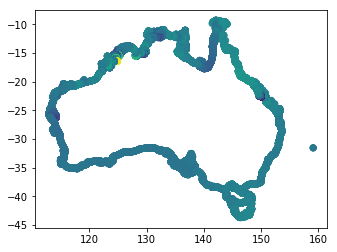

In [169]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(sealevelx_summary.X, sealevelx_summary.Y)]
sealevelx_summary = sealevelx_summary.drop(['X', 'Y'], axis=1)
crs = {'init': 'epsg:4326'}
sealevelx_gdf = GeoDataFrame(sealevelx_summary, crs=crs, geometry=geometry)
sealevelx_gdf.plot(column='sealevel_min') 

In [174]:
sealevelx_gdf = sealevelx_gdf.rename({'sealevel_min': 'min', 'sealevel_max': 'max'}, axis=1)

In [175]:
# sealevelx_gdf.iloc[:,0:-1] = sealevelx_gdf.iloc[:,0:-1].astype(np.float)     
sealevelx_gdf.columns = sealevelx_gdf.columns.astype(str)
sealevelx_gdf.to_file('sealevelx_stats.shp')

In [167]:
sealevelx_gdf.columns 

Index(['ID', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', 'date_min', 'date_max', 'sealevel_min',
       'sealevel_max', 'range', 'geometry'],
      dtype='object')

In [ ]:
# import pandas as pd

# # Sample data with ID
# id_df = pd.DataFrame({'ID': [0, 1, 2]})

# # Sample data with dates and values for each ID
# data_df = pd.DataFrame({'date': [pd.to_datetime('2011-02-23'), pd.to_datetime('2011-05-23'), pd.to_datetime('2011-08-23'),
#                                  pd.to_datetime('2011-02-23'), pd.to_datetime('2011-05-23'), pd.to_datetime('2011-08-23'),
#                                  pd.to_datetime('2011-02-23'), pd.to_datetime('2011-05-23'), pd.to_datetime('2011-08-23')],
#                         'Wet pixel percentage': [50, 24, 30, 56, 23, 23, 12, 55, 90],
#                         'Other data': [50, 24, 30, 56, 23, 23, 12, 55, 90]}, index=[0, 0, 0, 1, 1, 1, 2, 2, 2])


# Function to return quarterly values for a given ID
def quarterly_max(id_val):

    # Read in file from CSV (replace with code to load in CSV based on ID value)
    data_df_id = data_df.loc[id_val].copy()

    # Aggregate by max value per quarter
    aggregated_data = data_df_id.set_index('date').resample('Q', label='left').agg('max')

    # Keep just the data we want to write out
    aggregated_data = aggregated_data[['Wet pixel percentage']]

    # Return as pandas series
    return aggregated_data.iloc[:, 0]


# Compute quaterly maxes for each ID in the id_df dataframe
quarterly_maxes = id_df.apply(lambda x: quarterly_max(x.ID), axis=1)

# Get nicely formatted column names
col_names = [str(i)[0:10] for i in quarterly_maxes.columns]

# Insert back into dataframe
id_df[col_names] = quarterly_maxes